In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chi2
from datetime import timedelta

In [3]:
%matplotlib inline
sns.set(style='whitegrid')

In [5]:
# Function to fetch data
def fetch_data_from_yfinance(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Adj Close'] = pd.to_numeric(data['Adj Close'], errors='coerce')
    data.dropna(subset=['Adj Close'], inplace=True)
    return data['Adj Close']

In [7]:
# Fetch historical data
ticker = 'ETH-USD'
start_date = '2016-01-01'
end_date = '2024-08-08'
data = fetch_data_from_yfinance(ticker, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [9]:
# Calculate historical returns
returns = data.pct_change().dropna()

In [11]:
# Define VaR confidence level and calculate historical VaR
confidence_level = 0.95
VaR = np.percentile(returns, (1 - confidence_level) * 100)

In [13]:
# Determine violations
violations = returns < VaR
n_violations = violations.sum()
n = len(returns)
p = 1 - confidence_level

In [15]:
# Kupiec test statistic
LR_uc = -2 * np.log(((1 - n_violations/n)**(n - n_violations)) * ((n_violations/n)**n_violations)) \
       + 2 * np.log(((1 - p)**(n - n_violations)) * (p**n_violations))

In [17]:
# Compare with chi-squared distribution with 1 degree of freedom
p_value = chi2.sf(LR_uc, 1)

In [19]:
print(f"Number of VaR violations: {n_violations}")
print(f"Expected number of violations: {n * p:.2f}")
print(f"Kupiec test statistic: {LR_uc:.2f}")
print(f"p-value: {p_value:.4f}")

Number of VaR violations: 124
Expected number of violations: 123.15
Kupiec test statistic: -0.01
p-value: 1.0000


In [21]:
# Check for acceptance at 95% and 99% confidence levels
alpha_95 = 0.05
alpha_99 = 0.01

accept_95 = p_value > alpha_95
accept_99 = p_value > alpha_99

print(f"Accepted at 95% confidence level: {'Yes' if accept_95 else 'No'}")

Accepted at 95% confidence level: Yes


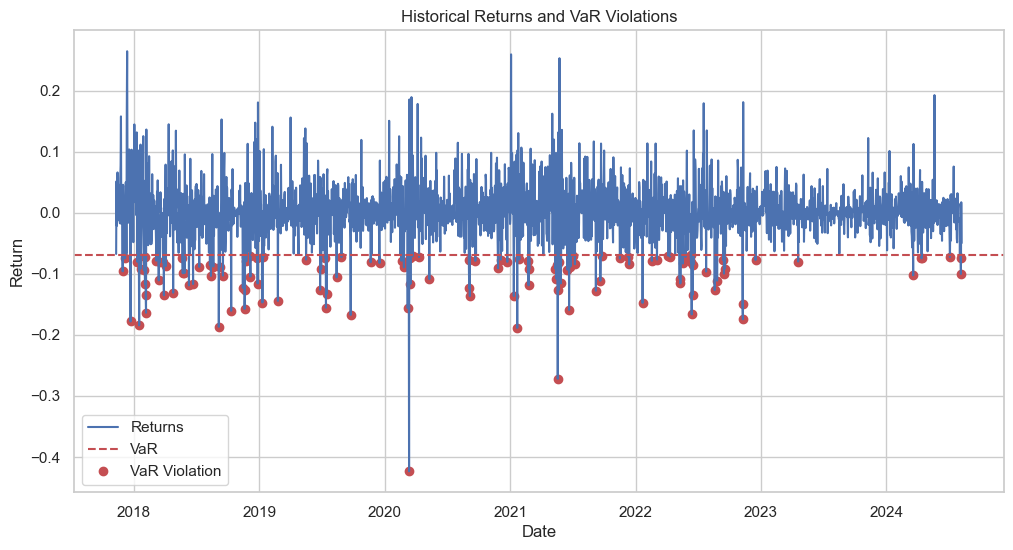

In [23]:
# Plotting historical VaR violations
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, label='Returns')
plt.axhline(y=VaR, color='r', linestyle='--', label='VaR')
plt.scatter(returns.index[violations], returns[violations], color='r', label='VaR Violation')
plt.title('Historical Returns and VaR Violations')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

In [25]:
num_simulations = 10000
num_days = 365  # 1 trading year

In [27]:
# Monte Carlo simulation
mean_return = returns.mean()
std_return = returns.std()
simulation_results = np.zeros((num_days, num_simulations))

In [29]:
for i in range(num_simulations):
    price_series = [data.iloc[-1]]
    for j in range(num_days):
        price = price_series[-1] * (1 + np.random.normal(mean_return, std_return))
        price_series.append(price)
    simulation_results[:, i] = price_series[1:]

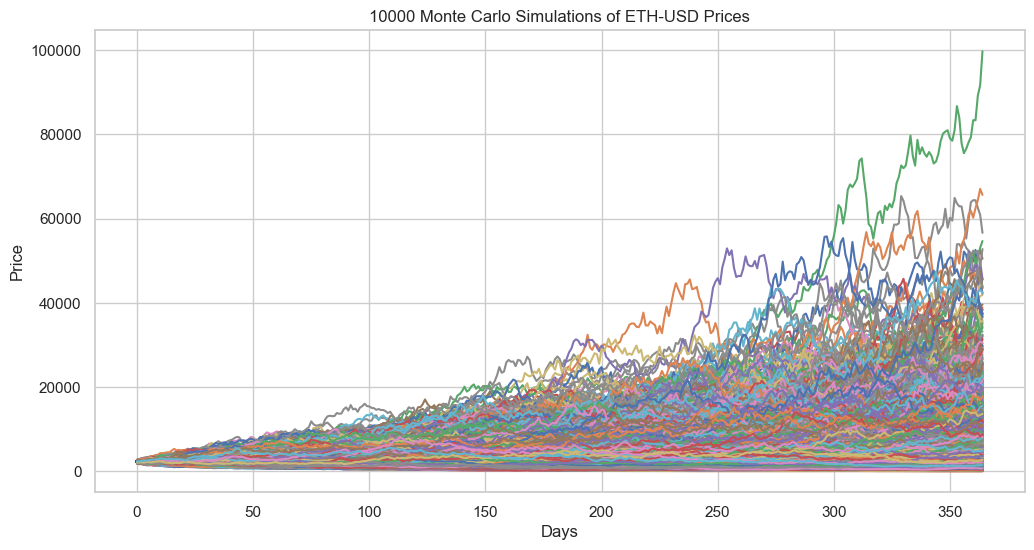

In [31]:
# Plotting Monte Carlo simulation results
plt.figure(figsize=(12, 6))
plt.plot(simulation_results)
plt.title(f'{num_simulations} Monte Carlo Simulations of ETH-USD Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

In [33]:
# Calculate and plot simulated VaR
simulation_end_prices = simulation_results[-1, :]
initial_price = data.iloc[-1]
returns_simulated = (simulation_end_prices - initial_price) / initial_price

In [35]:
VaR_simulated = np.percentile(returns_simulated, (1 - confidence_level) * 100)
print(f"Simulated Value at Risk (VaR) at {confidence_level * 100}% confidence level: {VaR_simulated * 100:.2f}%")

Simulated Value at Risk (VaR) at 95.0% confidence level: -69.55%


In [37]:
VaR_simulated = np.percentile(returns_simulated, (1 - confidence_level) * 100)
print(f"Simulated Value at Risk (VaR) at {confidence_level * 100}% confidence level: {VaR_simulated * 100:.2f}%")

Simulated Value at Risk (VaR) at 95.0% confidence level: -69.55%


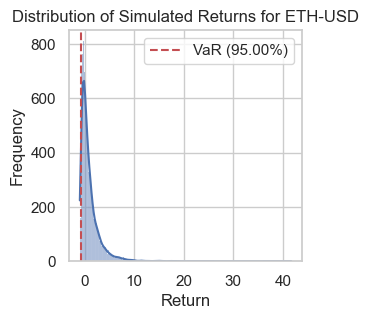

In [39]:
plt.figure(figsize=(3, 3))
sns.histplot(returns_simulated, kde=True)
plt.axvline(VaR_simulated, color='r', linestyle='--', label=f'VaR ({confidence_level * 100:.2f}%)')
plt.title(f'Distribution of Simulated Returns for ETH-USD')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

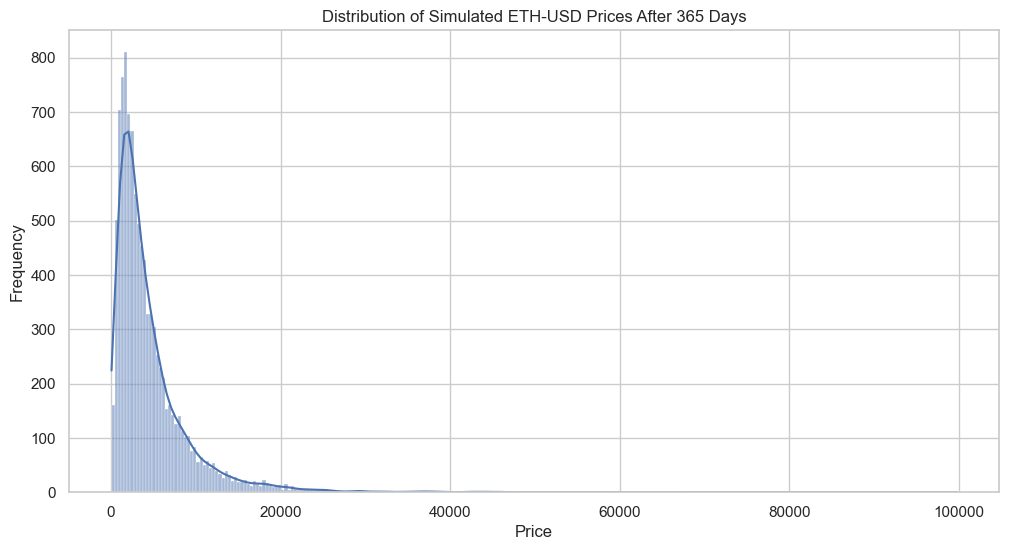

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(simulation_results[-1, :], kde=True)
plt.title(f'Distribution of Simulated ETH-USD Prices After {num_days} Days')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [43]:
percentiles = np.percentile(simulation_results[-1, :], [5, 50, 95])
print(f"5th percentile: ${percentiles[0]:,.2f}")
print(f"Median (50th percentile): ${percentiles[1]:,.2f}")
print(f"95th percentile: ${percentiles[2]:,.2f}")
percentiles = np.percentile(simulation_results[-1, :], [30, 50, 80])
print(f"30th percentile: ${percentiles[0]:,.2f}")
print(f"Median (50th percentile): ${percentiles[1]:,.2f}")
print(f"80th percentile: ${percentiles[2]:,.2f}")
percentiles = np.percentile(simulation_results[-1, :], [40, 50, 70])
print(f"40th percentile: ${percentiles[0]:,.2f}")
print(f"Median (50th percentile): ${percentiles[1]:,.2f}")
print(f"70th percentile: ${percentiles[2]:,.2f}")

5th percentile: $711.55
Median (50th percentile): $3,137.89
95th percentile: $13,353.53
30th percentile: $1,951.07
Median (50th percentile): $3,137.89
80th percentile: $6,642.59
40th percentile: $2,491.53
Median (50th percentile): $3,137.89
70th percentile: $5,013.90


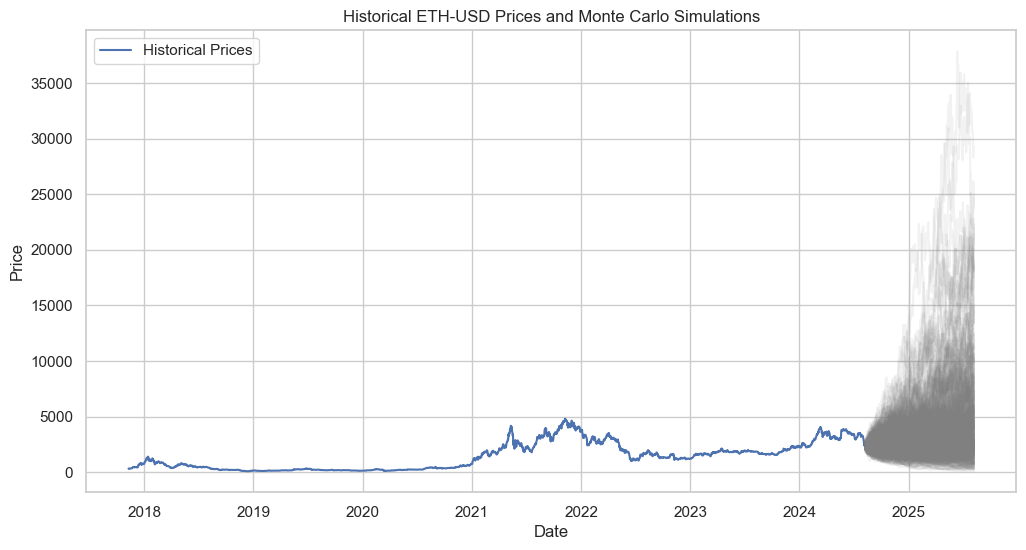

In [47]:
# Plotting historical and future simulated prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data.values, label='Historical Prices')
future_dates = [data.index[-1] + timedelta(days=i) for i in range(1, num_days + 1)]
for i in range(min(500, num_simulations)):  # Ensure we don't exceed the number of simulations
    plt.plot(future_dates, simulation_results[:, i], color='gray', alpha=0.1)
plt.title('Historical ETH-USD Prices and Monte Carlo Simulations')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()